In [1]:
import os
import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.utils import save_image
import torchvision
import torch.nn.functional as F

from IPython.display import Image

In [2]:
# Random seed 
torch.manual_seed(10001)

bs = 32

def to_var(x):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x)

def flatten(x):
    return to_var(x.view(x.size(0), -1))

def save_image(x, path='real_image.png'):
    torchvision.utils.save_image(x, path)

In [3]:

# Load Data
dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=False)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=bs, shuffle=True)

In [4]:
if not os.path.exists('/reconstructed'):
    os.makedirs('/reconstructed')

In [5]:
# Some prechecks on data loader

In [6]:
batch = list(data_loader)[0]
img,tar = batch
print(img.shape,tar.shape)
# [bs,c,h,w]

torch.Size([32, 1, 28, 28]) torch.Size([32])


In [7]:
# Fixed input for debugging
fixed_x, _ = next(iter(data_loader))
save_image(fixed_x)
fixed_x = flatten(fixed_x)
fixed_x.shape   # [bs,h*w]

torch.Size([32, 784])

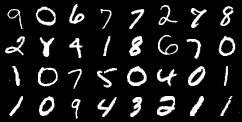

In [8]:
Image('real_image.png')

In [9]:
class VAE(nn.Module):
    def __init__(self, in_dim = 784, hidden_dim = 128, n_layers = 2, out_dim =784 ,z_dim= 10):
        
        super(VAE, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.z_dim = z_dim
        
        self.encoder_lstm = nn.LSTM(in_dim, hidden_dim, n_layers, batch_first=True)
                                          
        self.encoder_output = nn.Linear(hidden_dim, z_dim*2)
        
        self.decoder_lstm = nn.LSTM(z_dim, hidden_dim, n_layers, batch_first=True)
                                     
        self.decoder_output = nn.Linear(hidden_dim, in_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
                                     
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = to_var(torch.randn(*mu.size()))
        z = mu + std * esp
        return z
                                          
    def forward(self, x):
        
        # Encoder
        enc_hidden = self._init_hidden()
        enc,_ = self.encoder_lstm(x,enc_hidden)
        enc = self.relu(enc)

        # Reparameterize
        z_var = self.encoder_output(enc)    
        mu,logvar = torch.chunk(z_var, 2, dim=2)   # [bs,c,z_var]    
        z = self.reparameterize(mu, logvar)
        
        # Decoder
        dec_hidden = self._init_hidden()
        dec,_ = self.decoder_lstm(z,dec_hidden)
        dec = self.relu(dec)
        dec = self.sigmoid(self.decoder_output(dec))
        
        return dec, mu, logvar
    
    
    def _init_hidden(self):
        return torch.zeros(self.n_layers, bs, self.hidden_dim).cuda(), torch.zeros(self.n_layers, bs, self.hidden_dim).cuda()
        

In [10]:
vae = VAE()
if torch.cuda.is_available():
    vae.cuda()
vae

VAE(
  (encoder_lstm): LSTM(784, 128, num_layers=2, batch_first=True)
  (encoder_output): Linear(in_features=128, out_features=20, bias=True)
  (decoder_lstm): LSTM(10, 128, num_layers=2, batch_first=True)
  (decoder_output): Linear(in_features=128, out_features=784, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [11]:
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

In [12]:
def loss_fn(recon_x, x, mu, logvar,eps):
    BCE = F.binary_cross_entropy(recon_x + eps, x, size_average=False)
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu**2 -  logvar.exp())
    return BCE + KLD

In [13]:
epochs = 10
eps = torch.Tensor([1e-10]).cuda()

for epoch in range(epochs):
    for idx, (images, _) in enumerate(data_loader):
        
        images = flatten(images).unsqueeze(1)
#         images = flatten(images)
        recon_images, mu, logvar = vae(images)
        loss = loss_fn(recon_images, images, mu, logvar,eps)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        if idx%100 == 0:
            print("Epoch[{}/{}] Loss: {:.3f}".format(epoch+1, epochs, loss.item()/bs))
    
            recon_x, _, _ = vae(fixed_x.unsqueeze(1))
            save_image(recon_x.view(recon_x.size(0), 1, 28, 28).data.cpu(), f'recon_image_{epoch}_{idx}.png')
            

C:\Users\saran\Anaconda3\envs\tensor\lib\site-packages\torch\nn\_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch[1/10] Loss: 543.664
Epoch[1/10] Loss: 204.133
Epoch[1/10] Loss: 210.702
Epoch[1/10] Loss: 209.415
Epoch[1/10] Loss: 203.316
Epoch[1/10] Loss: 220.746
Epoch[1/10] Loss: 202.235
Epoch[1/10] Loss: 205.125
Epoch[1/10] Loss: 183.194
Epoch[1/10] Loss: 222.586
Epoch[1/10] Loss: 194.847
Epoch[1/10] Loss: 194.867
Epoch[1/10] Loss: 199.106
Epoch[1/10] Loss: 185.568
Epoch[1/10] Loss: 191.850
Epoch[1/10] Loss: 181.438
Epoch[1/10] Loss: 187.180
Epoch[1/10] Loss: 183.377
Epoch[1/10] Loss: 189.241
Epoch[2/10] Loss: 168.972
Epoch[2/10] Loss: 189.305
Epoch[2/10] Loss: 167.899
Epoch[2/10] Loss: 186.779
Epoch[2/10] Loss: 172.965
Epoch[2/10] Loss: 185.290
Epoch[2/10] Loss: 171.014
Epoch[2/10] Loss: 184.448
Epoch[2/10] Loss: 179.094
Epoch[2/10] Loss: 176.802
Epoch[2/10] Loss: 174.562
Epoch[2/10] Loss: 169.327
Epoch[2/10] Loss: 165.101
Epoch[2/10] Loss: 174.686
Epoch[2/10] Loss: 169.394
Epoch[2/10] Loss: 171.931
Epoch[2/10] Loss: 170.754
Epoch[2/10] Loss: 166.867
Epoch[2/10] Loss: 163.859
Epoch[3/10] 